In [2]:
%run 'init.ipynb'
save = get_figsave(3)

## Ecological interpretation

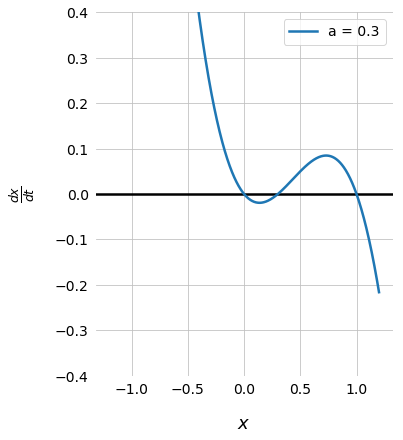

In [3]:
def xdot_1(x, a):
    return x * (1 - x) * (x - a)
    
def plot(ax, a, xlim=1.2, ylim=(-0.4, 0.4)):
    ax.axhline(0, c='black')
    X = np.linspace(-xlim, xlim, 1000)
    ax.plot(X, xdot_1(X, a), label=f'a = {a:g}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\frac{dx}{dt}$')
    ax.set_ylim(ylim)

fig, ax = plt.subplots(figsize=(6,6))
plot(ax, 0.3)
ax.legend();

## y = 0

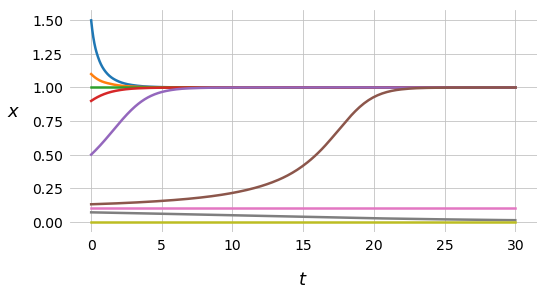

In [4]:
aa = 0.1
bb = 1.5

from scipy.integrate import solve_ivp

def f(t, x):
    return [xdot_1(x, aa)]
    
def plot_sim(ax, x_0=0.8):
    t_span = (0.01, 30)
    t_eval = np.logspace(*np.log10(t_span), 1000)
    sol = solve_ivp(f, (t_eval[0], t_eval[-1]), [x_0], t_eval=t_eval)
    ax.plot(sol.t, sol.y.flatten(), label=f'$x_0 = {x_0}$')

fig, ax = plt.subplots(figsize=(8,4))
for x_0 in reversed([0, 0.07, 0.1, 0.13, 0.5, 0.9, 1, 1.1, 1.5]):
    plot_sim(ax, x_0)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$', rotation=0);
# ax.legend();
save(fig, 'time_sim')

## Fixed points

In [5]:
x,y,a,b,c,d = sp.symbols('x,y,a,b,c,d')

def get_subs(cc=1):
     return dict(a=aa, b=bb, c=cc)

xdot_full = x * (x - a) * (1 - x) - b*x*y
ydot_full = x*y - c*y - d

xdot = xdot_full
ydot = ydot_full.subs(d, 0)

F = sp.Matrix([xdot, ydot])
J = F.jacobian([x, y])

fp = sp.solve(F, {x,y})

In [6]:
J0 = J.subs(fp[0])
J0.det(), J0.trace()

In [7]:
J0.eigenvects(simplify=True)

⎡⎛       ⎡⎡1⎤⎤⎞  ⎛       ⎡⎡0⎤⎤⎞⎤
⎢⎜-a, 1, ⎢⎢ ⎥⎥⎟, ⎜-c, 1, ⎢⎢ ⎥⎥⎟⎥
⎣⎝       ⎣⎣0⎦⎦⎠  ⎝       ⎣⎣1⎦⎦⎠⎦

In [8]:
J1 = J.subs(fp[1])
J1.det(), J1.trace()

In [9]:
J1.eigenvects(simplify=True)

⎡                   ⎛           ⎡⎡    b    ⎤⎤⎞⎤
⎢⎛          ⎡⎡1⎤⎤⎞  ⎜           ⎢⎢─────────⎥⎥⎟⎥
⎢⎜a - 1, 1, ⎢⎢ ⎥⎥⎟, ⎜-c + 1, 1, ⎢⎢a + c - 2⎥⎥⎟⎥
⎢⎝          ⎣⎣0⎦⎦⎠  ⎜           ⎢⎢         ⎥⎥⎟⎥
⎣                   ⎝           ⎣⎣    1    ⎦⎦⎠⎦

In [10]:
J2 = J.subs(fp[2])
J2.det(), J2.trace()

In [11]:
J2.eigenvects(simplify=True)

⎡⎛          ⎡⎡-a⋅b  ⎤⎤⎞                      ⎤
⎢⎜          ⎢⎢──────⎥⎥⎟                      ⎥
⎢⎜          ⎢⎢ 2    ⎥⎥⎟  ⎛   2         ⎡⎡1⎤⎤⎞⎥
⎢⎜a - c, 1, ⎢⎢a  - c⎥⎥⎟, ⎜- a  + a, 1, ⎢⎢ ⎥⎥⎟⎥
⎢⎜          ⎢⎢      ⎥⎥⎟  ⎝             ⎣⎣0⎦⎦⎠⎥
⎣⎝          ⎣⎣  1   ⎦⎦⎠                      ⎦

In [12]:
J3 = J.subs(fp[3])
J3.det(), sp.simplify(J3.trace())

In [13]:
A = J3.evalf(subs=get_subs())
AA = np.array(A).astype(np.float).round(2)

array([[-0.9, -1.5],
       [-0, 0]])

## fp 3 path

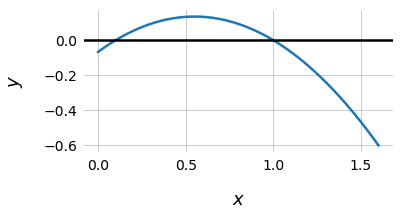

In [14]:
root_x = sp.lambdify(c, fp[3][x].subs(dict(a=aa, b=bb)))
root_y = sp.lambdify(c, fp[3][y].subs(dict(a=aa, b=bb)))

cs = np.linspace(0, 1.6)

fig, ax = plt.subplots()
ax.plot(root_x(cs), root_y(cs))
ax.axhline(c='black')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_aspect('equal');

## Phase space

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 1.5, y: -0.47}]


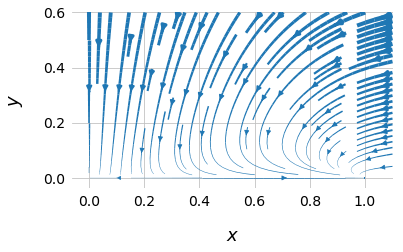

In [17]:
def eval_fp(c):
    return [{coord: p[coord].evalf(2, subs=get_subs(c)) for coord in (x,y)} for p in fp]

def get_grid(c):
    x_grid, y_grid = np.meshgrid(np.linspace(0, 1.1, 200),
                                 np.linspace(0, 0.6, 200),
                                )
    xdot_np = sp.lambdify((x,y), xdot.subs(get_subs(cc=c)))
    ydot_np = sp.lambdify((x,y), ydot.subs(get_subs(cc=c)))

    xdot_grid = xdot_np(x_grid, y_grid)
    ydot_grid = ydot_np(x_grid, y_grid)
    
    return x_grid, y_grid, xdot_grid, ydot_grid


def plot_grid(c):
    print(eval_fp(c))
    grid = get_grid(c)
    fig, ax = streamplot(*grid, speed=1, lw_0=0.2)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    return fig, ax


plot_grid(c=1.5);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 1.1, y: -0.067}]


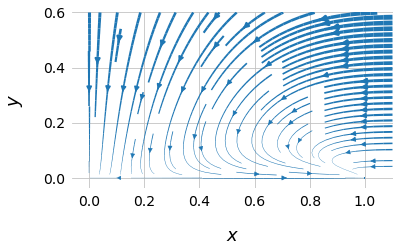

In [18]:
plot_grid(c=1.1);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.90, y: 0.053}]


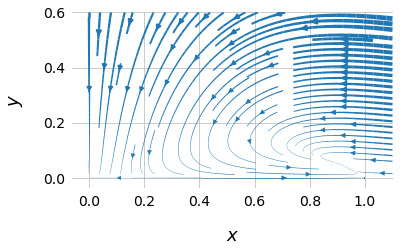

In [19]:
plot_grid(c=0.9);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.70, y: 0.12}]


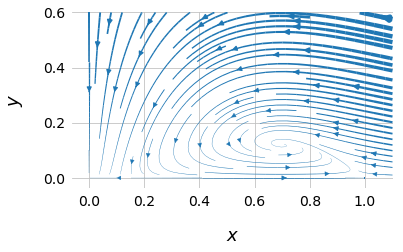

In [20]:
plot_grid(c=0.7);

Inwards flow

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.60, y: 0.13}]


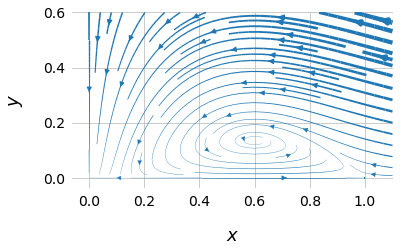

In [21]:
plot_grid(c=0.6);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.50, y: 0.13}]


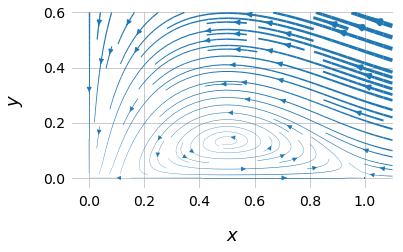

In [22]:
plot_grid(c=0.5);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.45, y: 0.13}]


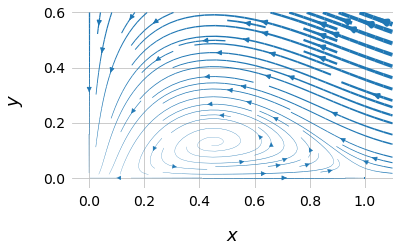

In [23]:
plot_grid(c=0.45);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.45, y: 0.13}]


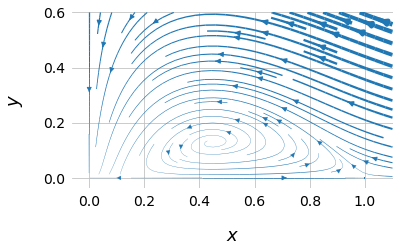

In [31]:
plot_grid(c=0.44664);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.38, y: 0.12}]


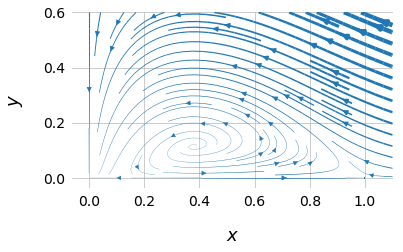

In [24]:
plot_grid(c=0.38);

Outwards flow

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.30, y: 0.093}]


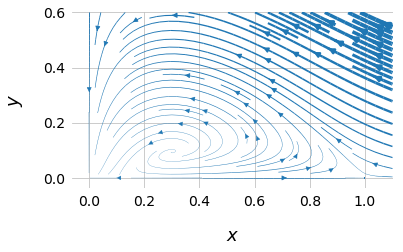

In [26]:
plot_grid(c=0.3);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.12, y: 0.012}]


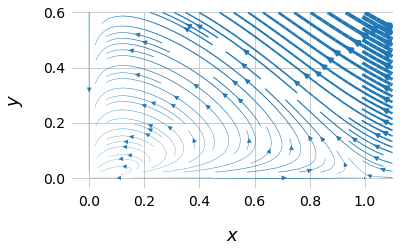

In [28]:
plot_grid(c=0.12);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0.070, y: -0.019}]


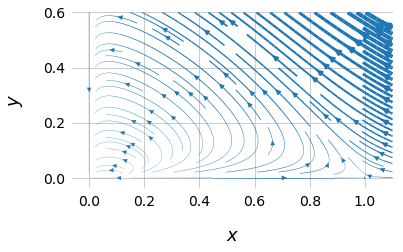

In [29]:
plot_grid(c=0.07);

[{x: 0, y: 0}, {x: 1.0, y: 0}, {x: 0.10, y: 0}, {x: 0, y: -0.067}]


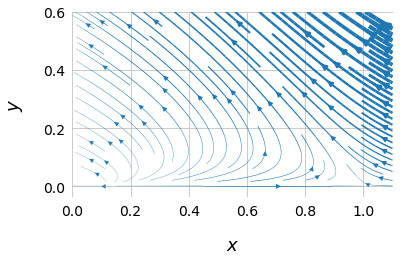

In [30]:
plot_grid(c=0);

## fp 3 eig

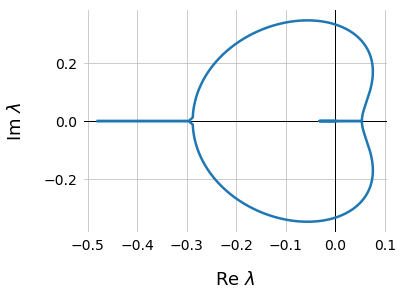

In [21]:
ev = list(J3.eigenvals().keys())[0]
ev_np = sp.lambdify((c,), ev.subs(dict(a=aa, b=bb)))

fig, ax = plt.subplots()

cs = np.linspace(0, 0.9, 5000)
lambdas = ev_np(cs+0j)
ax.axvline(color='black', lw=1)
ax.axhline(color='black', lw=1)
ax.plot(lambdas.real, lambdas.imag, 'C0')
ax.plot(lambdas.real, -lambdas.imag, 'C0')
ax.set_ylabel(r'Im $\lambda$');
ax.set_xlabel(r'Re $\lambda$');
save(fig, 'eigenheart')

## .

## Simulations

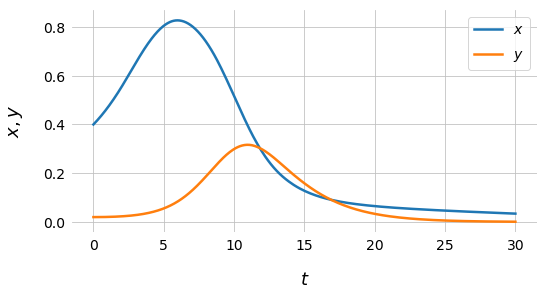

In [22]:
def sim2(c=0.4, x_0=0.4, y_0=0.02):
    
    xdot_np = sp.lambdify((x,y), xdot.subs(get_subs(cc=c)))
    ydot_np = sp.lambdify((x,y), ydot.subs(get_subs(cc=c)))

    def f(t, y):
        return [xdot_np(y[0], y[1]), ydot_np(y[0], y[1])]

    t_span = (0.01, 30)
    t_eval = np.logspace(*np.log10(t_span), 1000)
    sol = solve_ivp(f, (t_eval[0], t_eval[-1]), [x_0, y_0], t_eval=t_eval)

    fig, ax = plt.subplots(figsize=(8,4))
    ax.plot(sol.t, sol.y[0,:], label='$x$')
    ax.plot(sol.t, sol.y[1,:], label='$y$')
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x, y$', rotation=90);
    ax.legend()
    return fig, ax

fig, ax = sim2();
# save(fig, 'xy_time_sim')

## Coco ik

In [25]:
xdot_full_filled = xdot_full.subs(dict(a=aa, b=bb))
ydot_full_filled = ydot_full.subs(dict(a=aa, b=bb))

F_full = sp.Matrix([xdot_full_filled, ydot_full_filled])

⎡-1.5⋅x⋅y + x⋅(-x + 1)⋅(x - 0.1)⎤
⎢                               ⎥
⎣        -c⋅y - d + x⋅y         ⎦

In [26]:
J_full = F_full.jacobian([x, y])

⎡x⋅(-x + 1) - x⋅(x - 0.1) - 1.5⋅y + (-x + 1)⋅(x - 0.1)  -1.5⋅x⎤
⎢                                                             ⎥
⎣                          y                            -c + x⎦

For a given $c$, we want to know where the fixed points are, i.e. (x,y) solution(s).

In [27]:
# sp.solve({xdot_full, ydot_full}, {x, y})
# Nope, alas

from scipy.optimize import root

F_full_np = sp.lambdify((x,y,c,d), F_full)
J_full_np = sp.lambdify((x,y,c,d), J_full)

f = lambda x, c, d: F_full_np(x[0], x[1], c, d).astype(float).flatten()
JJ = lambda x, c, d: J_full_np(x[0], x[1], c, d).astype(float)


def plot_bifurc(dd=0, x_span = (-1.1, 1.1), c_span = (-1.5, 1.5)):
    c_space = np.linspace(*c_span, 100)
#     guess = [0.4, 0.12]
    guess_x, guess_y = np.meshgrid(np.linspace(0, 1.1, 20),
                                   np.linspace(0, 0.15, 20),
                                  )
#     fp = np.zeros((c_space.size, 2))
    fp = []

    for i, cc in enumerate(c_space):
        for j in range(guess_x.shape[0]):
            for k in range(guess_y.shape[0]):
                guess = [guess_x[j,k], guess_y[j,k]]
                rota = root(f, x0=guess, args=(cc,dd), jac=JJ).x
                fp.append(rota)
                # guess = fp[i,:]

#     fig, (left, right) = plt.subplots(ncols=2, figsize=(9,5))
#     left.plot(fp[:,0], c_space, 'C2.', lw=2, ms=6)
#     right.plot(fp[:,1], c_space, 'C2.', lw=2, ms=6)
#     left.set_xlabel('$x$')
#     left.set_ylabel('$c$')
#     right.set_xlabel('$y$')
#     right.set_ylabel('$c$')
#     return fig, (left, right)
    return fp

fp_list = plot_bifurc();

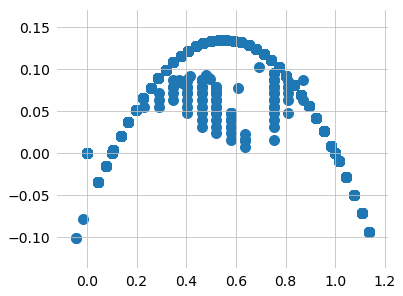

In [28]:
fp_mash = np.stack(fp_list)
plt.scatter(fp_mash[:,0], fp_mash[:,1])

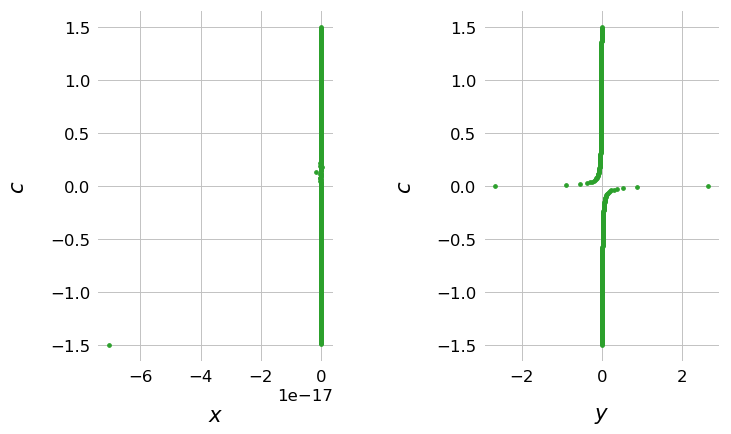

In [320]:
plot_bifurc(0.01);

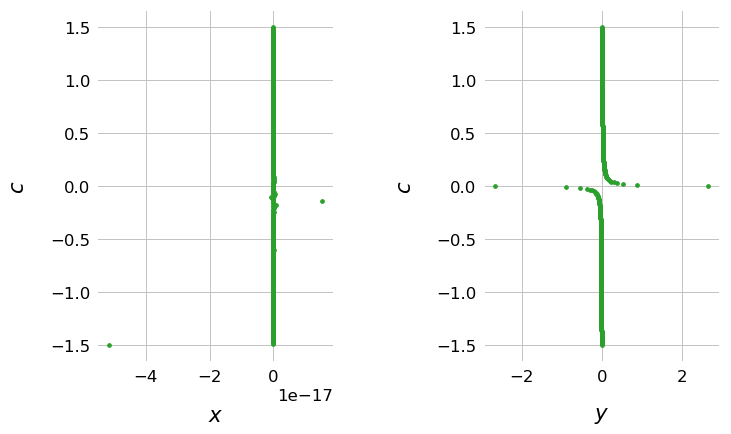

In [321]:
plot_bifurc(-0.01);